In [ ]:
!pip install utils datasets transformers numpy scipy seaborn matplotlib gdown

In [13]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from utils import *

import datasets
from datasets import load_dataset, load_metric

import scipy
import numpy as np
import pandas as pd

import gdown
import os

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [14]:
def load_data_from_drive(file_url, output_path):
    # Extract file ID from URL
    file_id = file_url.split("/d/")[1].split("/view")[0]

    # Construct download link
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Download file
    gdown.download(download_url, output_path, quiet=False)

# Load the data from my drive
load_data_from_drive("https://drive.google.com/file/d/1bhrvIGgsKgndZZeNOoXaOIZU8WqyN3in/view?usp=drive_link", "E1.mat")
load_data_from_drive("https://drive.google.com/file/d/1aW7bYXEzp_0hytdizV_oo5n7C8woPlz6/view?usp=drive_link", "E2.mat")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1bhrvIGgsKgndZZeNOoXaOIZU8WqyN3in
From (redirected): https://drive.google.com/uc?id=1bhrvIGgsKgndZZeNOoXaOIZU8WqyN3in&confirm=t&uuid=f641cbff-d2ae-4116-a2bf-ab5f7a32854a
To: /E1.mat
100%|██████████| 151M/151M [00:05<00:00, 27.9MB/s] 
Downloading...
From (uriginal): https://drive.google.com/uc?id=1aW7bYXEzp_0hytdizV_oo5n7C8woPlz6
From (redirected): https://drive.google.com/uc?id=1aW7bYXEzp_0hytdizV_oo5n7C8woPlz6&confirm=t&uuid=bbded861-4ac6-4d19-a239-40b21079f9c0
To: /E2.mat
100%|██████████| 244M/244M [00:06<00:00, 37.1MB/s] 


In [ ]:
# Import the data
df1 = scipy.io.loadmat("E1.mat")
df2 = scipy.io.loadmat("E2.mat")

emg1 = pd.DataFrame(df1["emg"])
emg2 = pd.DataFrame(df2["emg"])

acc1 = pd.DataFrame(df1["acc"])
acc2 = pd.DataFrame(df2["acc"])

glove1 = pd.DataFrame(df1["glove"])
glove2 = pd.DataFrame(df2["glove"])

stimulus1 = pd.DataFrame(df1["stimulus"])
stimulus2 = pd.DataFrame(df2["stimulus"])

restimulus1 = pd.DataFrame(df1["restimulus"])
restimulus2 = pd.DataFrame(df2["restimulus"])

repetition1 = pd.DataFrame(df1["repetition"])
repetition2 = pd.DataFrame(df2["repetition"])

rerepetition1 = pd.DataFrame(df1["rerepetition"])
rerepetition2 = pd.DataFrame(df2["rerepetition"])

In [ ]:
# We will use a Linear model to find the angles of our joints

## Maximum angles for each corresponding joint
Max_angles = np.array([
    [15, 50, 80, 0, 0, 120, 90, 0, 120, 90, 90, 0, 120, 90, 90, 0, 120, 90, 90, 0, 0, 0]
]).reshape(-1, 1)

def GetAngles(gloves_data, max_angles):
    # calculate the min and max of the data
    min_val = gloves_data.min()
    max_val = gloves_data.max()

    # normalize it
    Normalized_data = ((gloves_data - min_val) / (max_val - min_val))

    # find the angles
    fing_angles = np.array(Normalized_data) * max_angles.T

    # convert to DataFrame
    fing_gloves = pd.DataFrame(fing_angles, columns = [f"angles_glove_{i+1}" for i in range(22)])

    return (fing_gloves)

E1 = GetAngles(glove1, Max_angles)
E2 = GetAngles(glove2, Max_angles)

In [ ]:
# Prepare the data for training

# Drop unused signals
y_train1 = E1.drop(["angles_glove_4", "angles_glove_5", "angles_glove_8", "angles_glove_12", "angles_glove_16", "angles_glove_20", "angles_glove_21", "angles_glove_22"], axis = 1)
y_train2 = E2.drop(["angles_glove_4", "angles_glove_5", "angles_glove_8", "angles_glove_12", "angles_glove_16", "angles_glove_20", "angles_glove_21", "angles_glove_22"], axis = 1)

# Merge Excersice 1 and 2
y_train = pd.concat([y_train1 ,y_train2])
X_train = pd.concat([emg1, emg2])

print(y_train1.shape)
print(y_train2.shape)

print(X_train.shape)
print(y_train.shape)

# NOTE: I will use the collected data to fine tuning the model we are going to build so we don't need test data in this phase

# X_test1 = X_train.iloc[:200000,:]
# X_test2 = X_train.iloc[-200000:,:]
# X_test = pd.concat([X_test1, X_test2])

# y_test1 = y_train.iloc[:200000,:]
# y_test2 = y_train.iloc[-200000:,:]
# y_test = pd.concat([y_test1, y_test2])

# y_train = y_train.iloc[200000:,:].iloc[:-200000,:]
# X_train = X_train.iloc[200000:,:].iloc[:-200000,:]

# print(X_train.shape)
# print(y_train.shape)

# print(X_test.shape)
# print(y_test.shape)

# Convert the Dataframe to Tensor
train = torch.tensor(X_train.values.astype(np.float32))
# test = torch.tensor(X_test.values.astype(np.float32))

train_target = torch.tensor(y_train.values.astype(np.float32))
# test_target = torch.tensor(y_test.values.astype(np.float32))

In [22]:
train_data = TensorDataset(train, train_target)
# test_data = TensorDataset(test, test_target)

batch_size = 100000
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## training

In [ ]:
# Define the device to work on
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device0 = torch.device('cuda:0')
# device1 = torch.device('cuda:1')
# device2 = torch.device('cuda:2')
# device3 = torch.device('cuda:3')

print(device)
print(torch.cuda.device_count())

# !export CUDA_VISIBLE_DEVICES=0,1,2,3

In [24]:
class my_model(nn.Module):
    def __init__(self):
        super().__init__()        
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(in_features = 12, out_features = 128)
        self.layer2 = nn.Linear(in_features = 128, out_features = 256)
        self.layer3 = nn.Linear(in_features = 256, out_features = 1024)
        self.layer4 = nn.Linear(in_features = 1024, out_features = 4096)
        self.layer5 = nn.Linear(in_features = 4096, out_features = 4096)
        self.layer6 = nn.Linear(in_features = 4096, out_features = 2048)
        self.layer7 = nn.Linear(in_features = 2048, out_features = 512)
        self.layer8 = nn.Linear(in_features = 512, out_features = 14)

    def forward(self, inp):
        x = self.relu(self.layer1(inp))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.relu(self.layer6(x))
        x = self.relu(self.layer7(x))
        x = self.layer8(x)
        return (x)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Build and define your model
model = my_model()
model.to(device)

# Define the Loss function and the Optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

# Specify the number of epochs
epochs = 10

# Instantiate lists to save the loss values during the training process
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    train_loss = 0

    # Training mode
    model.train()
    for train_x, train_y in train_loader:

        train_x = train_x.to(device)
        train_y = train_y.to(device)

        # Feedforward
        y_pred = model(train_x)

        # At the start of each ****** Epoch
        optimizer.zero_grad()

        # Calculate the loss function
        loss = loss_fn(y_pred, train_y)
        train_loss += loss

        # Do the back probagation and update the parameters
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Evaluation mode
    model.eval()

    # with torch.inference_mode():
        
    #     loss_test = 0

    #     for test_x, test_y in test_loader:
            
    #         test_x, test_y = test_x.to(device), test_y.to(device)

    #         # Feedforward again for the evaluation phase
    #         y_pred_test = model(test_x)

    #         # Calculate the loss for the test dataset
    #         loss_test += loss_fn(y_pred_test, test_y)

    #     loss_test /= len(test_loader)

    # # Append loss values for the training process
    train_loss_values.append(train_loss)
    # test_loss_values.append(loss_test) # .cpu().detach().numpy()
    epoch_count.append(epoch)
    print(f"Epoch : {epoch + 1} | train_Loss: {train_loss}") # | test_Loss: {loss_test}")

Epoch : 1 | train_Loss: 782.2628784179688 | test_Loss: 345.39703369140625
Epoch : 2 | train_Loss: 322.82220458984375 | test_Loss: 313.3749694824219
Epoch : 3 | train_Loss: 318.16827392578125 | test_Loss: 312.6052551269531
Epoch : 4 | train_Loss: 318.0813903808594 | test_Loss: 313.5200500488281
Epoch : 5 | train_Loss: 318.0838317871094 | test_Loss: 313.81854248046875
Epoch : 6 | train_Loss: 318.05615234375 | test_Loss: 313.486328125
Epoch : 7 | train_Loss: 318.1033630371094 | test_Loss: 316.3216857910156
Epoch : 8 | train_Loss: 318.1255798339844 | test_Loss: 310.7686462402344
Epoch : 9 | train_Loss: 318.0785827636719 | test_Loss: 313.77447509765625
Epoch : 10 | train_Loss: 318.08795166015625 | test_Loss: 313.43609619140625


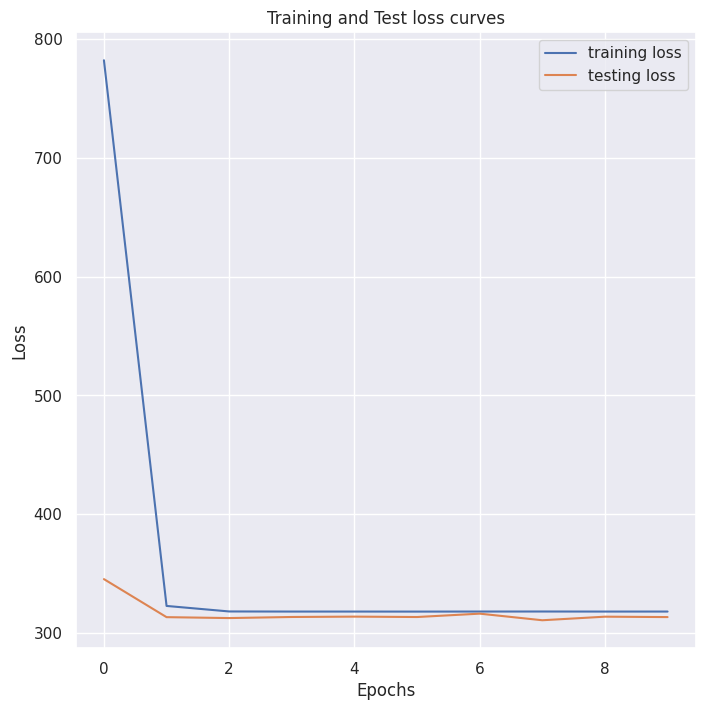

In [28]:
train_loss_values0 = [train_loss_values[i].cpu().detach().numpy() for i in range(len(train_loss_values))]
# test_loss_values0 = [test_loss_values[i].cpu().detach().numpy() for i in range(len(test_loss_values))]
# Plot the loss curves
plt.figure(figsize = (8, 8))
plt.plot(epoch_count, train_loss_values0, label = "training loss")
# plt.plot(epoch_count, test_loss_values0, label = "testing loss")
plt.title("Training and Test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## We can try some manifold methods to represent the input data

In [ ]:
# Prepare the data for training

# Merge Excersice 1 and 2
X_train = pd.concat([emg1, emg2])

print(X_train.shape)

X_test1 = X_train.iloc[:200000,:]
X_test2 = X_train.iloc[-200000:,:]
X_test = pd.concat([X_test1, X_test2])

X_train = X_train.iloc[200000:,:].iloc[:-200000,:]

print(X_train.shape)
print(X_test.shape)

# Convert the Dataframe to Tensor
train = torch.tensor(X_train.values.astype(np.float32))
test = torch.tensor(X_test.values.astype(np.float32))

# the input is the same as the output
train_data = TensorDataset(train, train)
test_data = TensorDataset(test, test)

batch_size = 100000
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [8]:
# In future we need to use non-linear activation function and see the resulting representation of the data in the latent spcase
# in case using linear activation function the result will be as PCA
class my_model(nn.Module):
    def __init__(self):
        super().__init__()        
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(in_features = 12, out_features = 256)
        self.layer2 = nn.Linear(in_features = 256, out_features = 128)
        self.layer3 = nn.Linear(in_features = 128, out_features = 64)
        self.layer4 = nn.Linear(in_features = 64, out_features = 8)
        self.layer5 = nn.Linear(in_features = 8, out_features = 64)
        self.layer6 = nn.Linear(in_features = 64, out_features = 128)
        self.layer7 = nn.Linear(in_features = 128, out_features = 256)
        self.layer8 = nn.Linear(in_features = 256, out_features = 12)

    def forward(self, inp):
        x = self.relu(self.layer1(inp))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.relu(self.layer6(x))
        x = self.relu(self.layer7(x))
        x = self.layer8(x)
        return (x)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Build and define your model
model = my_model()
model.to(device)

# Define the Loss function and the Optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters())

# Specify the number of epochs
epochs = 10

# Instantiate lists to save the loss values during the training process
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    # Training mode
    model.train()

    train_x = train.to(device)
    train_y = train.to(device)

    # Feedforward
    y_pred = model(train_x)

    # At the start of each ****** Epoch
    optimizer.zero_grad()

    # Calculate the loss function
    train_loss = loss_fn(y_pred, train_y)

    # Do the back probagation and update the parameters
    train_loss.backward()
    optimizer.step()

    # Evaluation mode
    model.eval()

    with torch.inference_mode():

        test_x, test_y = test.to(device), test.to(device)

        # Feedforward again for the evaluation phase
        y_pred_test = model(test_x)

        # Calculate the loss for the test dataset
        loss_test = loss_fn(y_pred_test, test_y)

    # Append loss values for the training process
    train_loss_values.append(train_loss.cpu().detach().numpy())
    test_loss_values.append(loss_test.cpu().detach().numpy())
    epoch_count.append(epoch)
    print(f"Epoch : {epoch + 1} | train_Loss: {train_loss} | test_Loss: {loss_test}")

Epoch : 1 | train_Loss: 0.0011768636759370565 | test_Loss: 0.0003951121470890939
Epoch : 2 | train_Loss: 0.0003951124963350594 | test_Loss: 6.98897274560295e-05
Epoch : 3 | train_Loss: 6.988988752709702e-05 | test_Loss: 5.1771166909020394e-05
Epoch : 4 | train_Loss: 5.177111233933829e-05 | test_Loss: 0.00016651416081003845
Epoch : 5 | train_Loss: 0.0001665140298428014 | test_Loss: 0.0002422880061203614
Epoch : 6 | train_Loss: 0.00024228791880887002 | test_Loss: 0.00022821660968475044
Epoch : 7 | train_Loss: 0.0002282165951328352 | test_Loss: 0.00015953421825543046
Epoch : 8 | train_Loss: 0.0001595343346707523 | test_Loss: 8.081179112195969e-05
Epoch : 9 | train_Loss: 8.081203850451857e-05 | test_Loss: 2.7789566956926137e-05
Epoch : 10 | train_Loss: 2.7789888918050565e-05 | test_Loss: 1.0119157195731532e-05


In [ ]:
# Plot the loss curves
plt.figure(figsize = (8, 8))
plt.plot(epoch_count, train_loss_values, label = "training loss")
plt.plot(epoch_count, test_loss_values, label = "testing loss")
plt.title("Training and Test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
class my_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(in_features = 12, out_features = 256)
        self.layer2 = nn.Linear(in_features = 256, out_features = 128)
        self.layer3 = nn.Linear(in_features = 128, out_features = 64)
        self.layer4 = nn.Linear(in_features = 64, out_features = 8)
        self.layer5 = nn.Linear(in_features = 8, out_features = 64)
        self.layer6 = nn.Linear(in_features = 64, out_features = 128)
        self.layer7 = nn.Linear(in_features = 128, out_features = 256)
        self.layer8 = nn.Linear(in_features = 256, out_features = 12)

    def forward(self, inp):
        x = self.relu(self.layer1(inp))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.relu(self.layer6(x))
        x = self.relu(self.layer7(x))
        x = self.layer8(x)
        return (x)

# Build and define your model
model = my_model()
model.to(device0)
model = nn.DataParallel(model)

# Define the Loss function and the Optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters())

# Specify the number of epochs
epochs = 10

# Instantiate lists to save the loss values during the training process
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    # Training mode
    model.train()

    # Feedforward
    y_pred = model(train.to(device0))
    
    # At start of each Epoch
    optimizer.zero_grad()

    # Calculate the loss function
    loss = loss_fn(y_pred, train.to(device0))

    # Do the back probagation and update the parameters
    loss.backward()
    optimizer.step()

    # Evaluation mode
    model.eval()

    with torch.inference_mode():

        # Feedforward again for the evaluation phase
        y_pred_test = model(test.to(device0))

        # Calculate the loss for the test dataset
        loss_test = loss_fn(y_pred_test, test.to(device0))

    # Append loss values for the training process
    train_loss_values.append(loss.cpu().detach().numpy())
    test_loss_values.append(loss_test.cpu().detach().numpy())
    epoch_count.append(epoch)
    print(f"Epoch : {epoch + 1} | train_Loss: {loss} | test_Loss: {loss_test}")

In [ ]:
class my_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(in_features = 12, out_features = 256)
        self.layer2 = nn.Linear(in_features = 256, out_features = 128)
        self.layer3 = nn.Linear(in_features = 128, out_features = 64)
        self.layer4 = nn.Linear(in_features = 64, out_features = 8)
        self.layer5 = nn.Linear(in_features = 8, out_features = 64)
        self.layer6 = nn.Linear(in_features = 64, out_features = 128)
        self.layer7 = nn.Linear(in_features = 128, out_features = 256)
        self.layer8 = nn.Linear(in_features = 256, out_features = 12)

    def forward(self, inp):
        x = self.relu(self.layer1(inp))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.relu(self.layer6(x))
        x = self.relu(self.layer7(x))
        x = self.layer8(x)
        return (x)

# Build and define your model
model = my_model()
model.to(device0)
model = nn.DataParallel(model)

# Define the Loss function and the Optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters())

# Specify the number of epochs
epochs = 10

# Instantiate lists to save the loss values during the training process
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    train_loss = 0
    for train_x, train_y in train_loader:

        train_x, train_y = train_x.to(device0), train_y.to(device0)
        # Training mode
        model.train()

        # Feedforward
        y_pred = model(train_x)
        
        # At start of each Epoch
        optimizer.zero_grad()

        # Calculate the loss function
        loss = loss_fn(y_pred, train_y)
        train_loss += loss

        # Do the back probagation and update the parameters
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Evaluation mode
    model.eval()

    with torch.inference_mode():

        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device0), test_y.to(device0)

            # Feedforward again for the evaluation phase
            y_pred_test = model(test_x)

            # Calculate the loss for the test dataset
            loss_test += loss_fn(y_pred_test, test_y)

        loss_test /= len(test_loader)

    # Append loss values for the training process
    train_loss_values.append(loss.cpu().detach().numpy())
    test_loss_values.append(loss_test)
    epoch_count.append(epoch)
    print(f"Epoch : {epoch + 1} | train_Loss: {loss} | test_Loss: {loss_test}")

In [ ]:
# Plot the loss curves
plt.figure(figsize = (8, 8))
plt.plot(epoch_count, train_loss_values, label = "training loss")
plt.plot(epoch_count, test_loss_values, label = "testing loss")
plt.title("Training and Test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(emg1)
plt.figure(figsize = (8, 8))
plt.bar(range(1, len(pca.explained_variance_ratio_) +  1), pca.explained_variance_ratio_)
plt.xlabel("NO.Components")
plt.ylabel("Variance Captured by each component")
plt.title("Variance Explained")
plt.show()

var_cum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize = (8, 8))
plt.bar(range(1, len(var_cum) + 1), var_cum)
plt.xlabel("NO.Components")
plt.ylabel("Variance Captured by these number of components")
plt.title("Cumulative Variance Explained")
plt.show()

print(sum(var_cum < 0.99))  # 9 component
print(sum(var_cum < 0.95))  # 7 component